In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display

p = query.Prometheus('http://192.168.178.64:9090')
step="1s"

# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.
NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]
# The default range for sliding window aggregations
DEFAULT_RANGE="10s"

# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = "{devices=\"\"}"

# Utils

In [16]:
def printmd(string):
    display(Markdown(string))
    
def remove_meta_columns(df):
    cols = [col for col in df.columns if col not in ['measurement','delta']]
    return df[cols]

    
def describe_measurement_dataframe(df):
    printmd("### Total ")
    display(remove_meta_columns(df).describe())
    
    printmd("### Per Measurement")
    display(df[df.columns.difference(['seconds'])].groupby('measurement').describe().unstack(1))

def prepare_query_range_as_dataframe(measurement_no, query, start, end, step=step) -> pd.DataFrame:
    print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step} ...")
    metrics = p.query_range(query, start, end, step)

    # We can't be sure that we have a value for each second, so we calculate the difference between the timestamps
    # and att those to the dataframe
    metrics['tvalue'] = metrics.index
    metrics['delta'] = (metrics['tvalue'] - metrics['tvalue'].min()).fillna(0).astype('timedelta64[s]')
    metrics['seconds'] = metrics['delta'].dt.total_seconds().astype(int)
    metrics.drop(['tvalue'], inplace=True, axis=1)
    # metrics = metrics.assign(seconds=range(len(metrics)))
    metrics = metrics.assign(measurement=measurement_no)
    
    # summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_query_metrics_as_dataframe(measurement_no, query, end):
    print(f"[Measurement {measurement_no}] Querying '{query}' at {end} ...")
    metrics = p.query(query, end).to_frame()
    metrics.columns = ['value']
    metrics = metrics.assign(measurement=measurement_no)

    summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query_fn, df):
    result = [prepare_query_range_as_dataframe(idx, query_fn(start, duration, end), start, end) for idx, (start, duration, end) in enumerate(zip(df['Start'], df['Duration'], df['End']), 1)]
    result = pd.concat(result)
    return result


def prepare_series(query_fn, df):
    result = [prepare_query_metrics_as_dataframe(idx, query_fn(start, duration, end), end) for idx, (start, duration, end) in enumerate(zip(df['Start'], df['Duration'], df['End']), 1)]
    result = pd.concat(result)
    return result


def mark_outliers(df, fence=2.22):
    # Select only numeric columns
    cols = df.select_dtypes('number').columns
    df_sub = df.loc[:, cols]
    
    # Calculate IQR
    iqr = df_sub.quantile(0.75, numeric_only=False) - df_sub.quantile(0.25, numeric_only=False)
    lim = np.abs((df_sub - df_sub.median()) / iqr) < fence
    
    # Replace Outliers with NaN
    df.loc[:, cols] = df_sub.where(lim, np.nan)
    
    # Replace all NaN values
    return df


def summarize_outliers(df, fence=2.22):
    marked_outliers = mark_outliers(df, fence)
    diff = df.compare(marked_outliers)
    
    # No Outliers, no problem
    if diff.size == 0:
        return
    
    diff.name = 'Outliers'
    print('Outliers detected, please check manually')
    print(diff)
    

def drop_outliers(df, fence=2.22):
    cols = df.select_dtypes('number').columns
    return mark_outliners(df, fence).dropna(how='any', subset=cols)

# Data Preparation

In [17]:
Q_POWER=lambda start,duration,end: '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}'
Q_CPU_SECONDS=lambda start,duration,end: f"avg by (mode) (increase(node_cpu_seconds_total[{DEFAULT_RANGE}]))"
Q_CPU_UTILIZATION=lambda start,duration,end: f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)"
Q_CPU_FREQUENCY=lambda start, duration, end: "avg by (instance) (node_cpu_scaling_frequency_hertz)"
Q_MEMORY_USAGE=lambda start, duration, end: f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Cached_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Buffers_bytes[{DEFAULT_RANGE}])) / avg_over_time(node_memory_MemTotal_bytes[{DEFAULT_RANGE}])))
    """
Q_NETWORK_RX_BYTES=lambda start, duration, end: f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_BYTES=lambda start, duration, end: f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_PACKETS=lambda start, duration, end: f"sum by(device) (increase(node_network_receive_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_PACKETS=lambda start, duration, end: f"sum by(device) (increase(node_network_transmit_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_RATE=lambda start, duration, end: f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_NETWORK_TX_RATE=lambda start, duration, end: f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_DISK_IO_SECONDS=lambda start, duration, end: f"increase(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}])"
Q_DISK_IO_RATE=lambda start, duration, end: f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))"
Q_INTERRUPTS=lambda start, duration, end: f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{DEFAULT_RANGE}]) > 0)"

def prepare_power_metrics(measurement_dataframe):
    power_metrics = prepare_dataframe(Q_POWER, measurement_dataframe)
    power_metrics.columns = ['Current', 'Watts', 'Voltage', 'delta', 'seconds', 'measurement']
    return power_metrics

def prepare_cpu_seconds_in_mode(measurement_dataframe):
    return prepare_series(Q_CPU_SECONDS, measurement_dataframe)

def prepare_cpu_utilization(measurement_dataframe):
    return prepare_dataframe(Q_CPU_UTILIZATION, measurement_dataframe)

def prepare_cpu_frequency(measurement_dataframe):
    return prepare_dataframe(Q_CPU_FREQUENCY, measurement_dataframe)

def prepare_memory_utilization(measurement_dataframe):
    return prepare_dataframe(Q_MEMORY_USAGE, measurement_dataframe)

def prepare_network_received_bytes(measurement_dataframe):
    return prepare_series(Q_NETWORK_RX_BYTES, measurement_dataframe)

def prepare_network_transmitted_bytes(measurement_dataframe):
    return prepare_series(Q_NETWORK_TX_BYTES, measurement_dataframe)

def prepare_network_average_receive_rate(measurement_dataframe):
    return prepare_dataframe(Q_NETWORK_RX_RATE, measurement_dataframe)

def prepare_network_average_transmit_rate(measurement_dataframe):
    return prepare_dataframe(Q_NETWORK_TX_RATE, measurement_dataframe)

def prepare_total_disk_io_seconds(measurement_dataframe):
    return prepare_series(Q_DISK_IO_SECONDS, measurement_dataframe)

def prepare_disk_io_rate(measurement_dataframe):
    return prepare_dataframe(Q_DISK_IO_RATE, measurement_dataframe)

def prepare_interrupts(measurement_dataframe):
    return prepare_series(Q_INTERRUPTS, measurement_dataframe)

In [18]:
# This is just a try to load everything into a single dataframe.
# It's not working yet, but I'm going to leave it here for now.
def prepare_humongous_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    power_metrics = prepare_power_metrics(df).set_index(['measurement', 'seconds'])
    cpu_seconds = prepare_dataframe(lambda start, duration, end: "avg by (mode) (node_cpu_seconds_total)", df).set_index(['measurement', 'seconds'])
    memory_free = prepare_dataframe(lambda start, duration, end: "node_memory_MemFree_bytes", df).set_index(['measurement','seconds'])
    memory_chached = prepare_dataframe(lambda start, duration, end: "node_memory_Cached_bytes", df).set_index(['measurement','seconds'])
    memory_buffers = prepare_dataframe(lambda start, duration, end: "node_memory_Buffers_bytes", df).set_index(['measurement', 'seconds'])
    memory_total = prepare_dataframe(lambda start, duration, end: "node_memory_MemTotal_bytes", df).set_index(['measurement', 'seconds'])
    network_receive_bytes = prepare_dataframe(lambda start, duration, end: f"node_network_receive_bytes_total{net_filter_label}", df).set_index(['measurement', 'seconds'])
    network_transmit_bytes = prepare_dataframe(lambda start, duration, end: f"node_network_transmit_bytes{net_filter_label}", df).set_index(['measurement', 'seconds'])
    disk_io_time_seconds = prepare_dataframe(lambda start, duration, end: f"node_disk_io_time_seconds_total{disk_filter_label}", df).set_index(['measurement', 'seconds'])
    interrupts = prepare_dataframe(lambda start, duration, end: f"sum by(devices, type) (node_interrupts_total{interrupts_filter} > 0)", df).set_index(['measurement', 'seconds'])

    df = pd.concat(
        [power_metrics, cpu_seconds, memory_free, memory_chached, memory_buffers, memory_total, network_receive_bytes, network_transmit_bytes, disk_io_time_seconds, interrupts], 
        axis=1,
        names=['measurement', 'seconds']
    )

    return df

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [19]:
bm = pd.read_csv('baseline.csv')
bm

,Start,End,Duration,Energy
0,1681634834,1681635134,5m,4


## Power Stats

In [20]:
power_metrics = prepare_power_metrics(bm)
describe_measurement_dataframe(power_metrics)

mean_per_second = power_metrics.groupby(by=['seconds']).mean()
display(mean_per_second.describe())


# printmd("### Current Measurment Plots")
# fg = sns.lmplot(
#       data=power_metrics, x="seconds", y="Current", col="measurement", col_wrap=5, height=3, scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Current (A)")
# plt.show(fg)

# printmd("### Voltage Measurment Plots")
# fg = sns.lmplot(
#     data=power_metrics, x="seconds", y="Voltage", col="measurement", col_wrap=5, height=3, scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Voltage (V)")
# plt.show(fg)

# printmd("### Watts Measurment Plots")
# fg = sns.lmplot(
#       data=power_metrics, x="seconds", y="Watts", col="measurement", col_wrap=5, height=3, scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Watts (W)")
# plt.show(fg)        

# printmd("### Mean Watts")

# mean_per_second = power_metrics.groupby(by=['seconds']).mean()
# display(mean_per_second.describe())

# fig = mean_per_second['Watts'].plot(drawstyle='steps')
# fig.set_xlabel("Time (s)")
# fig.set_ylabel("Watts (W)")
# plt.show(fig)

# fg = sns.lmplot(
#       data=mean_per_second.reset_index(), x="seconds", y="Watts", scatter=True
# )
# fg.set_xlabels("Time (s)")
# fg.set_ylabels("Watts (W)")
# plt.show(fg)    

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681634834 to 1681635134 with step 1s ...


### Total 

,Current,Watts,Voltage,seconds
count,301.000000,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203,150.000000
std,0.786951,0.497034,0.427307,87.035433
min,261.000000,47.000000,237.000000,0.000000
25%,262.000000,47.000000,237.000000,75.000000
50%,262.000000,47.000000,237.000000,150.000000
75%,263.000000,48.000000,237.000000,225.000000
max,265.000000,48.000000,238.000000,300.000000


### Per Measurement

                measurement
Current  count  1                        301.0
         mean   1                   262.259136
         std    1                     0.786951
         min    1                        261.0
         25%    1                        262.0
         50%    1                        262.0
         75%    1                        263.0
         max    1                        265.0
Voltage  count  1                        301.0
         mean   1                   237.239203
         std    1                     0.427307
         min    1                        237.0
         25%    1                        237.0
         50%    1                        237.0
         75%    1                        237.0
         max    1                        238.0
Watts    count  1                        301.0
         mean   1                    47.438538
         std    1                     0.497034
         min    1                         47.0
         25%    1               

,Current,Watts,Voltage,delta,measurement
count,301.000000,301.000000,301.000000,301,301.0
mean,262.259136,47.438538,237.239203,0 days 00:02:30,1.0
std,0.786951,0.497034,0.427307,0 days 00:01:27,0.0
min,261.000000,47.000000,237.000000,0 days 00:00:00,1.0
25%,262.000000,47.000000,237.000000,0 days 00:01:15,1.0
50%,262.000000,47.000000,237.000000,0 days 00:02:30,1.0
75%,263.000000,48.000000,237.000000,0 days 00:03:45,1.0
max,265.000000,48.000000,238.000000,0 days 00:05:00,1.0


## CPU

### CPU Time

In [21]:
cpu_metrics = prepare_cpu_seconds_in_mode(bm)
describe_measurement_dataframe(cpu_metrics)

total_mean_result = remove_meta_columns(cpu_metrics).groupby(level=0).mean()

display(total_mean_result)
# total_mean_result.plot.bar(ylabel='CPU seconds')

[Measurement 1] Querying 'avg by (mode) (increase(node_cpu_seconds_total[10s]))' at 1681635134 ...


### Total 

,value
count,8.000000
mean,1.248872
std,3.516367
min,0.000000
25%,0.000000
50%,0.000694
75%,0.011979
max,9.951389


### Per Measurement

              measurement
value  count  1              8.000000
       mean   1              1.248872
       std    1              3.516367
       min    1              0.000000
       25%    1              0.000000
       50%    1              0.000694
       75%    1              0.011979
       max    1              9.951389
dtype: float64

,value
"{mode=""idle""}",9.951389
"{mode=""iowait""}",0.000000
"{mode=""irq""}",0.000000
"{mode=""nice""}",0.000000
"{mode=""softirq""}",0.001389
"{mode=""steal""}",0.000000
"{mode=""system""}",0.004861
"{mode=""user""}",0.033333


### CPU Utilization

In [22]:
cpu_utilization = prepare_cpu_utilization(bm)
describe_measurement_dataframe(cpu_utilization)

grouped_mean = cpu_utilization.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

[Measurement 1] Querying 'avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{mode=""idle""}","{mode=""iowait""}","{mode=""irq""}","{mode=""nice""}","{mode=""softirq""}","{mode=""steal""}","{mode=""system""}","{mode=""user""}",seconds
count,301.000000,301.000000,301.0,301.0,301.000000,301.0,301.000000,301.000000,301.000000
mean,99.407577,0.001038,0.0,0.0,0.012159,0.0,0.068568,0.416182,150.000000
std,0.082584,0.002668,0.0,0.0,0.010580,0.0,0.014193,0.036469,87.035433
min,99.076389,0.000000,0.0,0.0,0.000000,0.0,0.027778,0.319444,0.000000
25%,99.361111,0.000000,0.0,0.0,0.000000,0.0,0.062500,0.395833,75.000000
50%,99.402778,0.000000,0.0,0.0,0.013889,0.0,0.069444,0.423611,150.000000
75%,99.451389,0.000000,0.0,0.0,0.020833,0.0,0.076389,0.444444,225.000000
max,99.840278,0.013889,0.0,0.0,0.041667,0.0,0.111111,0.493056,300.000000


### Per Measurement

                      measurement
delta          count  1                          301
               mean   1              0 days 00:02:30
               std    1              0 days 00:01:27
               min    1              0 days 00:00:00
               25%    1              0 days 00:01:15
                                          ...       
{mode="user"}  min    1                     0.319444
               25%    1                     0.395833
               50%    1                     0.423611
               75%    1                     0.444444
               max    1                     0.493056
Length: 72, dtype: object

## Memory

In [23]:
memory_usage = prepare_memory_utilization(bm)
describe_measurement_dataframe(memory_usage)

grouped_mean = memory_usage.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylim=(-5,105),ylabel='%')

[Measurement 1] Querying '
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[10s]) + avg_over_time(node_memory_Cached_bytes[10s]) + avg_over_time(node_memory_Buffers_bytes[10s])) / avg_over_time(node_memory_MemTotal_bytes[10s])))
    ' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{instance=""192.168.178.79:9100"",job=""node""}",seconds
count,301.000000,301.000000
mean,1.063313,150.000000
std,0.004534,87.035433
min,1.055603,0.000000
25%,1.059990,75.000000
50%,1.063192,150.000000
75%,1.065911,225.000000
max,1.077417,300.000000


### Per Measurement

                                                    measurement
delta                                        count  1                          301
                                             mean   1              0 days 00:02:30
                                             std    1              0 days 00:01:27
                                             min    1              0 days 00:00:00
                                             25%    1              0 days 00:01:15
                                             50%    1              0 days 00:02:30
                                             75%    1              0 days 00:03:45
                                             max    1              0 days 00:05:00
{instance="192.168.178.79:9100",job="node"}  count  1                        301.0
                                             mean   1                     1.063313
                                             std    1                     0.004534
                       

## Network

### Received KBytes

In [24]:
network_received_bytes = prepare_network_received_bytes(bm)
describe_measurement_dataframe(network_received_bytes)

grouped_mean = network_received_bytes.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
# grouped_mean.plot.bar(ylabel='Received KBytes')

[Measurement 1] Querying 'sum by(device) (increase(node_network_receive_bytes_total{device=~"docker0|enp7s0|lo"}[10s])) / 1000' at 1681635134 ...


### Total 

,value
count,3.000000
mean,3.360000
std,5.819691
min,0.000000
25%,0.000000
50%,0.000000
75%,5.040000
max,10.080000


### Per Measurement

              measurement
value  count  1               3.000000
       mean   1               3.360000
       std    1               5.819691
       min    1               0.000000
       25%    1               0.000000
       50%    1               0.000000
       75%    1               5.040000
       max    1              10.080000
dtype: float64

In [25]:
network_average_receive_rate = prepare_network_average_receive_rate(bm)
describe_measurement_dataframe(network_average_receive_rate)

grouped_mean = network_average_receive_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

[Measurement 1] Querying 'avg by (device) (rate(node_network_receive_bytes_total{device=~"docker0|enp7s0|lo"}[10s]))' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}",seconds
count,301.0,301.000000,301.0,301.000000
mean,0.0,1045.552602,0.0,150.000000
std,0.0,43.988468,0.0,87.035433
min,0.0,944.666667,0.0,0.000000
25%,0.0,1012.444444,0.0,75.000000
50%,0.0,1042.666667,0.0,150.000000
75%,0.0,1073.333333,0.0,225.000000
max,0.0,1157.333333,0.0,300.000000


### Per Measurement

                           measurement
delta               count  1                          301
                    mean   1              0 days 00:02:30
                    std    1              0 days 00:01:27
                    min    1              0 days 00:00:00
                    25%    1              0 days 00:01:15
                    50%    1              0 days 00:02:30
                    75%    1              0 days 00:03:45
                    max    1              0 days 00:05:00
{device="docker0"}  count  1                        301.0
                    mean   1                          0.0
                    std    1                          0.0
                    min    1                          0.0
                    25%    1                          0.0
                    50%    1                          0.0
                    75%    1                          0.0
                    max    1                          0.0
{device="enp7s0"}   count  1     

### Sent KByte

In [26]:
network_transmitted_bytes = prepare_network_transmitted_bytes(bm)
describe_measurement_dataframe(network_transmitted_bytes)

grouped_mean = network_transmitted_bytes.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
# grouped_mean.plot.bar(ylabel='Sent KBytes')

[Measurement 1] Querying 'sum by(device) (increase(node_network_transmit_bytes_total{device=~"docker0|enp7s0|lo"}[10s])) / 1000' at 1681635134 ...


### Total 

,value
count,3.000000
mean,66.005926
std,114.325617
min,0.000000
25%,0.000000
50%,0.000000
75%,99.008889
max,198.017778


### Per Measurement

              measurement
value  count  1                3.000000
       mean   1               66.005926
       std    1              114.325617
       min    1                0.000000
       25%    1                0.000000
       50%    1                0.000000
       75%    1               99.008889
       max    1              198.017778
dtype: float64

In [27]:
network_average_transmit_rate = prepare_network_average_transmit_rate(bm)
describe_measurement_dataframe(network_average_transmit_rate)

grouped_mean = network_average_transmit_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Bytes')

[Measurement 1] Querying 'avg by (device) (rate(node_network_transmit_bytes_total{device=~"docker0|enp7s0|lo"}[10s]))' from 1681634834 to 1681635134 with step 1s ...


### Total 

,"{device=""docker0""}","{device=""enp7s0""}","{device=""lo""}",seconds
count,301.0,301.000000,301.0,301.000000
mean,0.0,19813.594684,0.0,150.000000
std,0.0,8.070060,0.0,87.035433
min,0.0,19785.111111,0.0,0.000000
25%,0.0,19808.444444,0.0,75.000000
50%,0.0,19814.222222,0.0,150.000000
75%,0.0,19819.000000,0.0,225.000000
max,0.0,19835.888889,0.0,300.000000


### Per Measurement

                           measurement
delta               count  1                          301
                    mean   1              0 days 00:02:30
                    std    1              0 days 00:01:27
                    min    1              0 days 00:00:00
                    25%    1              0 days 00:01:15
                    50%    1              0 days 00:02:30
                    75%    1              0 days 00:03:45
                    max    1              0 days 00:05:00
{device="docker0"}  count  1                        301.0
                    mean   1                          0.0
                    std    1                          0.0
                    min    1                          0.0
                    25%    1                          0.0
                    50%    1                          0.0
                    75%    1                          0.0
                    max    1                          0.0
{device="enp7s0"}   count  1     

# Disk

In [28]:
total_disk_io_seconds = prepare_total_disk_io_seconds(bm)

grouped_result = total_disk_io_seconds.groupby(level=0).mean()
display(grouped_result)

[Measurement 1] Querying 'increase(node_disk_io_time_seconds_total{device=~"sda"}[10s])' at 1681635134 ...


,value,measurement
"{device=""sda"",instance=""192.168.178.79:9100"",job=""node""}",0.0,1.0


In [29]:
disk_io_rate = prepare_disk_io_rate(bm)
describe_measurement_dataframe(power_metrics)

grouped_mean = disk_io_rate.groupby(by=['seconds']).mean()
grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
# grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='I/O seconds')

[Measurement 1] Querying 'avg by (device) (rate(node_disk_io_time_seconds_total{device=~"sda"}[10s]))' from 1681634834 to 1681635134 with step 1s ...


### Total 

,Current,Watts,Voltage,seconds
count,301.000000,301.000000,301.000000,301.000000
mean,262.259136,47.438538,237.239203,150.000000
std,0.786951,0.497034,0.427307,87.035433
min,261.000000,47.000000,237.000000,0.000000
25%,262.000000,47.000000,237.000000,75.000000
50%,262.000000,47.000000,237.000000,150.000000
75%,263.000000,48.000000,237.000000,225.000000
max,265.000000,48.000000,238.000000,300.000000


### Per Measurement

                measurement
Current  count  1                        301.0
         mean   1                   262.259136
         std    1                     0.786951
         min    1                        261.0
         25%    1                        262.0
         50%    1                        262.0
         75%    1                        263.0
         max    1                        265.0
Voltage  count  1                        301.0
         mean   1                   237.239203
         std    1                     0.427307
         min    1                        237.0
         25%    1                        237.0
         50%    1                        237.0
         75%    1                        237.0
         max    1                        238.0
Watts    count  1                        301.0
         mean   1                    47.438538
         std    1                     0.497034
         min    1                         47.0
         25%    1               

# Interrupts

In [30]:
interrupts = prepare_interrupts(bm)
describe_measurement_dataframe(interrupts)

grouped_mean = interrupts.groupby(level=0).mean()
grouped_mean.drop(['measurement'], inplace=True, axis=1)
display(grouped_mean)
# grouped_mean.plot.bar(ylabel='Interrupts')

[Measurement 1] Querying 'sum by (devices, type) (idelta(node_interrupts_total{devices=""}[10s]) > 0)' at 1681635134 ...


### Total 

,value
count,3.000000
mean,155.333333
std,208.696750
min,2.000000
25%,36.500000
50%,71.000000
75%,232.000000
max,393.000000


### Per Measurement

              measurement
value  count  1                3.000000
       mean   1              155.333333
       std    1              208.696750
       min    1                2.000000
       25%    1               36.500000
       50%    1               71.000000
       75%    1              232.000000
       max    1              393.000000
dtype: float64

,value
"{type=""CAL""}",71.0
"{type=""LOC""}",393.0
"{type=""RES""}",2.0


# Software Experiment

In [31]:
# Those are the variants we have measured
VARIANTS=["no-cache", "caffeine-cache", "redis-cache", "caffeine-redis-cache"]

# no-cache

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681993133 to 1681993246 with step 1s ...
[Measurement 1] Querying 'avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)' from 1681993133 to 1681993246 with step 1s ...
[Measurement 1] Querying 'avg by (instance) (node_cpu_scaling_frequency_hertz)' from 1681993133 to 1681993246 with step 1s ...
[Measurement 1] Querying '
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[10s]) + avg_over_time(node_memory_Cached_bytes[10s]) + avg_over_time(node_memory_Buffers_bytes[10s])) / avg_over_time(node_memory_MemTotal_bytes[10s])))
    ' from 1681993133 to 1681993246 with step 1s ...


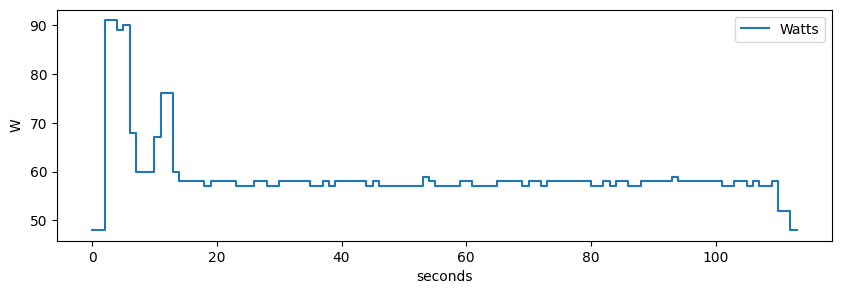

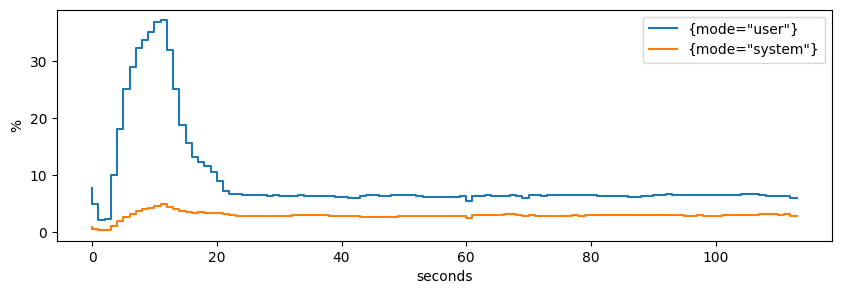

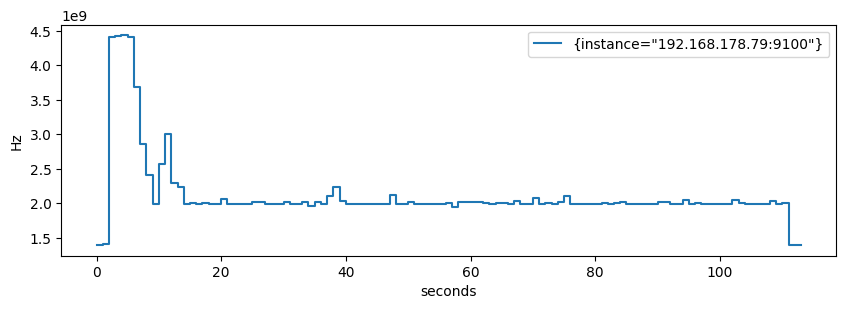

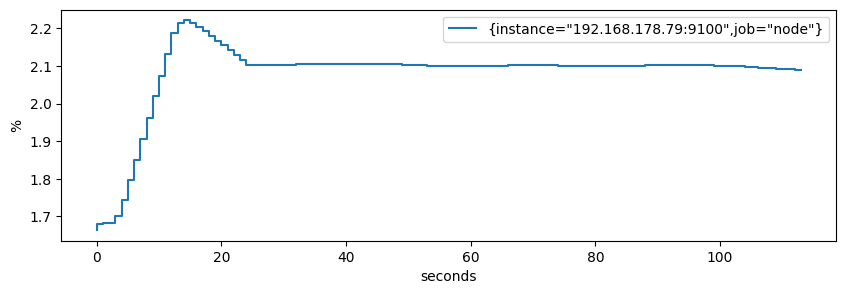

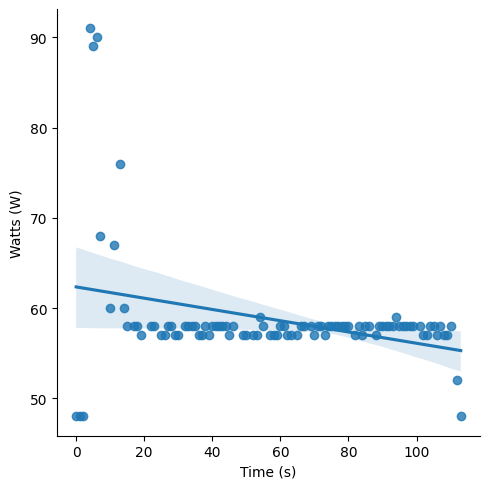

# caffeine-cache

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681993347 to 1681993460 with step 1s ...
[Measurement 1] Querying 'avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)' from 1681993347 to 1681993460 with step 1s ...
[Measurement 1] Querying 'avg by (instance) (node_cpu_scaling_frequency_hertz)' from 1681993347 to 1681993460 with step 1s ...
[Measurement 1] Querying '
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[10s]) + avg_over_time(node_memory_Cached_bytes[10s]) + avg_over_time(node_memory_Buffers_bytes[10s])) / avg_over_time(node_memory_MemTotal_bytes[10s])))
    ' from 1681993347 to 1681993460 with step 1s ...


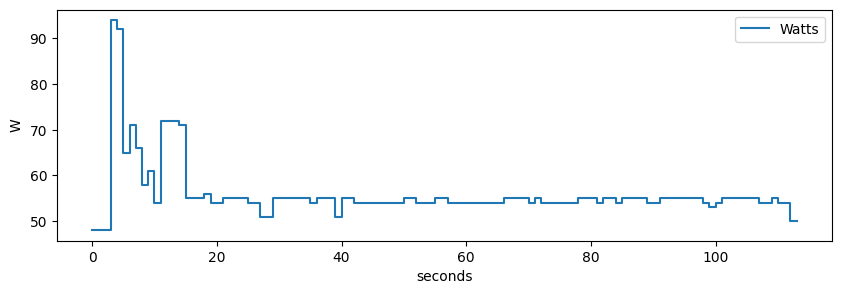

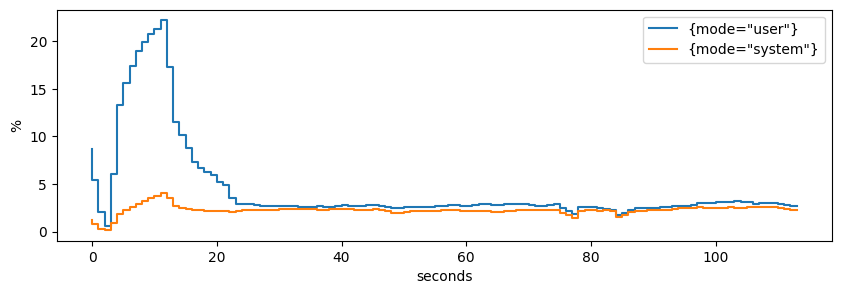

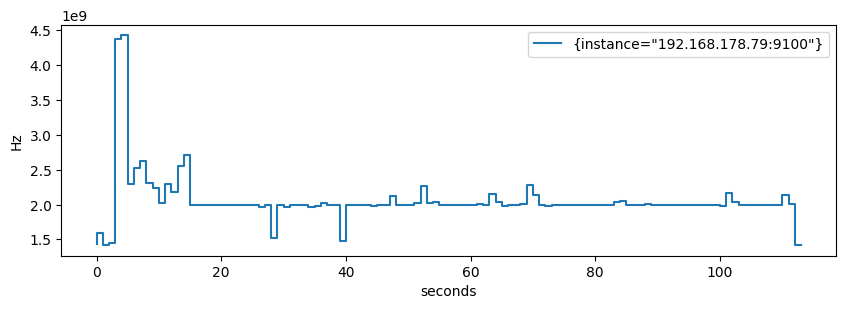

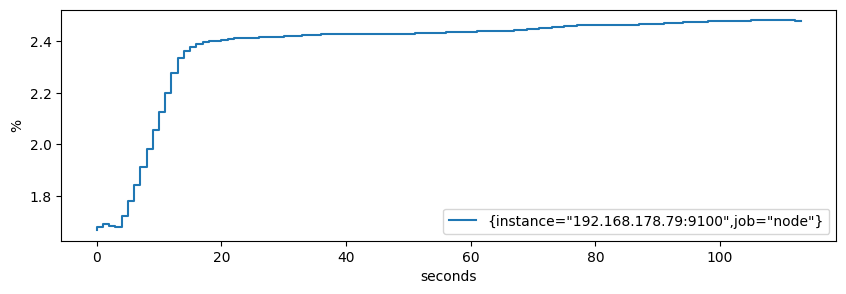

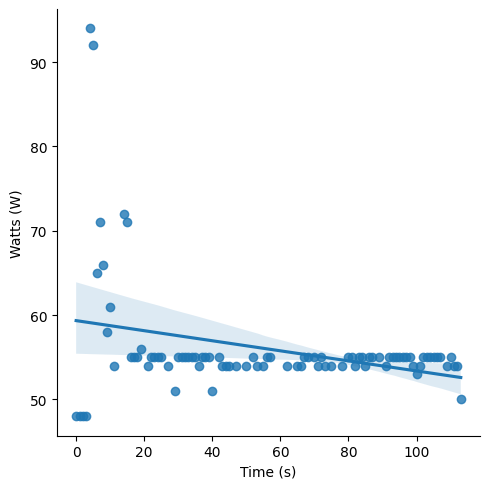

# redis-cache

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681993565 to 1681993678 with step 1s ...
[Measurement 1] Querying 'avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)' from 1681993565 to 1681993678 with step 1s ...
[Measurement 1] Querying 'avg by (instance) (node_cpu_scaling_frequency_hertz)' from 1681993565 to 1681993678 with step 1s ...
[Measurement 1] Querying '
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[10s]) + avg_over_time(node_memory_Cached_bytes[10s]) + avg_over_time(node_memory_Buffers_bytes[10s])) / avg_over_time(node_memory_MemTotal_bytes[10s])))
    ' from 1681993565 to 1681993678 with step 1s ...


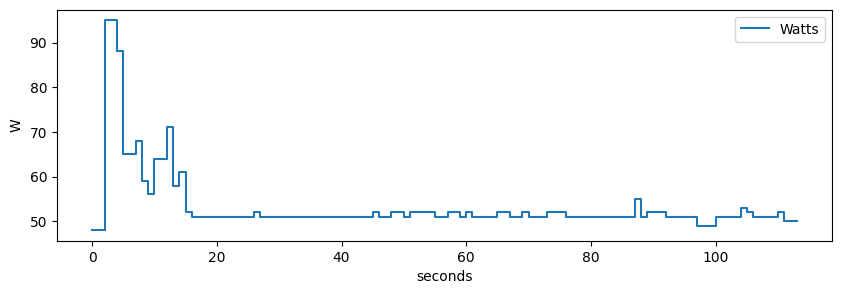

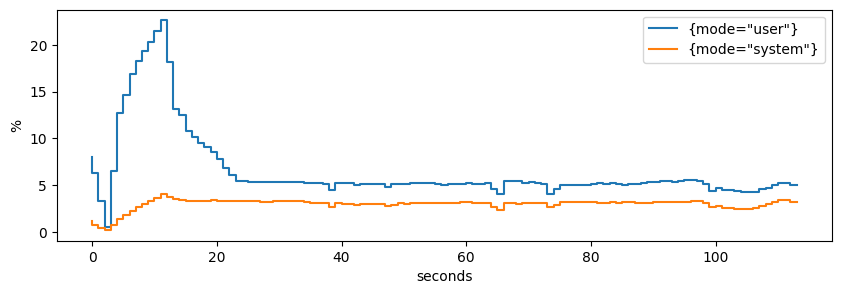

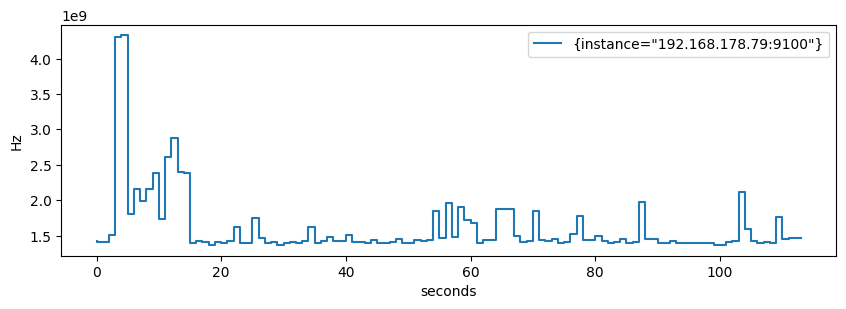

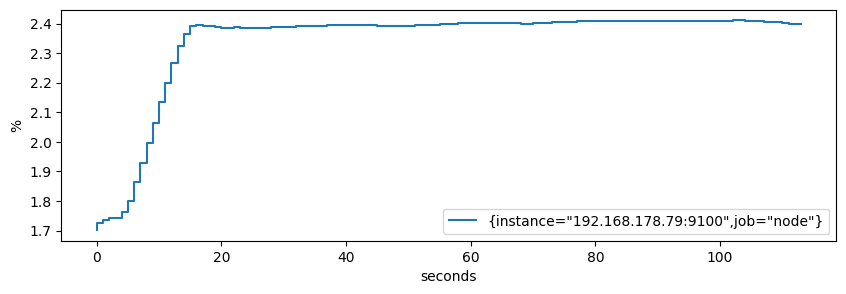

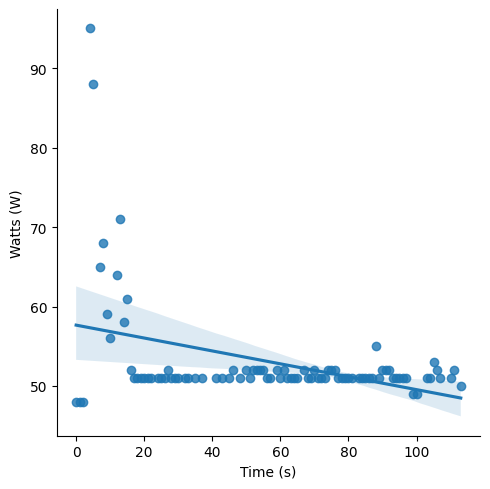

# caffeine-redis-cache

[Measurement 1] Querying '{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}' from 1681993780 to 1681993893 with step 1s ...
[Measurement 1] Querying 'avg by (mode) (rate(node_cpu_seconds_total[10s]) * 100)' from 1681993780 to 1681993893 with step 1s ...
[Measurement 1] Querying 'avg by (instance) (node_cpu_scaling_frequency_hertz)' from 1681993780 to 1681993893 with step 1s ...
[Measurement 1] Querying '
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[10s]) + avg_over_time(node_memory_Cached_bytes[10s]) + avg_over_time(node_memory_Buffers_bytes[10s])) / avg_over_time(node_memory_MemTotal_bytes[10s])))
    ' from 1681993780 to 1681993893 with step 1s ...


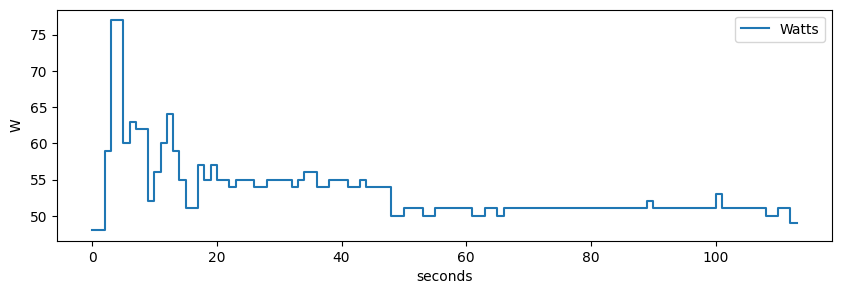

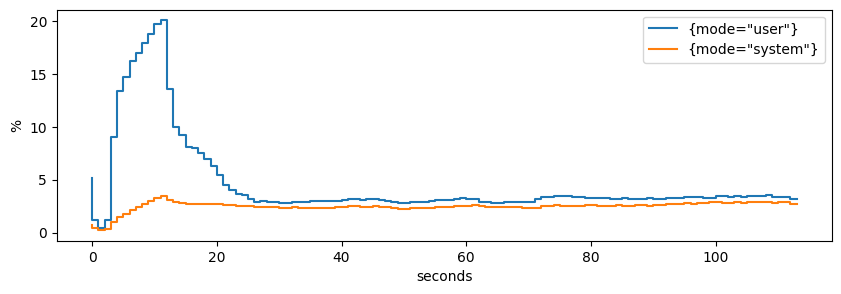

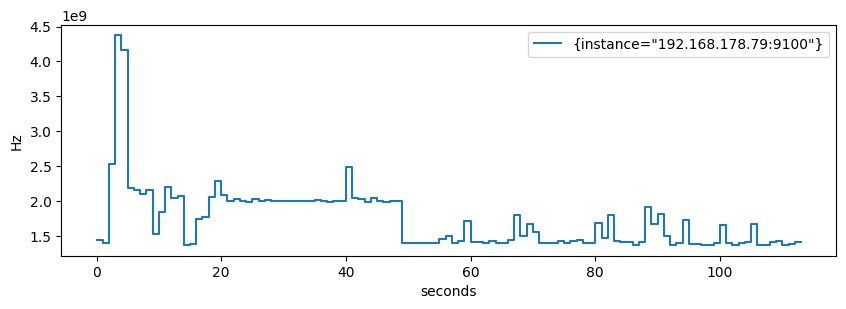

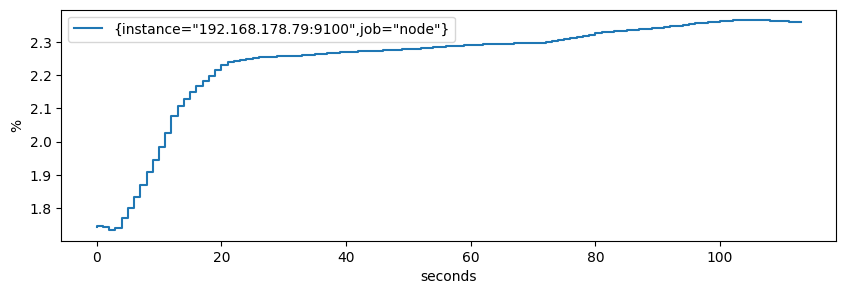

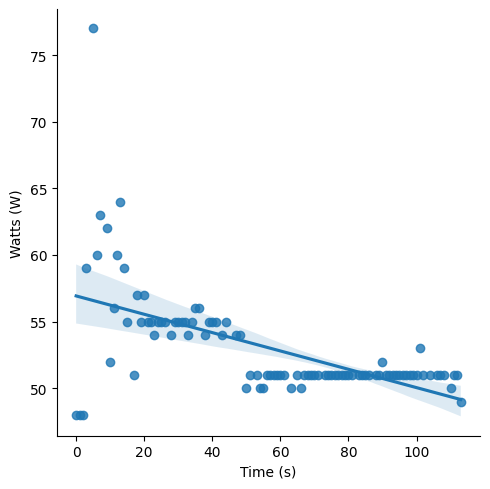

In [32]:
data_measurement = pd.read_csv("benchmark-log.csv")

for v in VARIANTS:
    display(Markdown("# " + v))
    df = data_measurement.loc[data_measurement['Variant'] == v]
    power_metrics = prepare_power_metrics(df)
    grouped_mean = power_metrics.groupby(by=['seconds']).mean()
    grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
    grouped_mean.plot(drawstyle='steps',y='Watts',figsize=(10,3),ylabel='W')

    cpu_utilization = prepare_cpu_utilization(df)
    grouped_mean = cpu_utilization.groupby(by=['seconds']).mean()
    grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
    grouped_mean.plot(y=['{mode="user"}','{mode="system"}'],drawstyle='steps',figsize=(10,3),ylabel='%')

    cpu_frequency = prepare_cpu_frequency(df)
    grouped_mean = cpu_frequency.groupby(by=['seconds']).mean()
    grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
    grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='Hz')

    memory_usage = prepare_memory_utilization(df)
    grouped_mean = memory_usage.groupby(by=['seconds']).mean()
    grouped_mean.drop(['measurement', 'delta'], inplace=True, axis=1)
    grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='%')

    # interrupts = prepare_interrupts(df)
    # grouped_mean = interrupts.groupby(level=0).mean()
    # grouped_mean.drop(['measurement'], inplace=True, axis=1)
    # display(grouped_mean)

    # disk_io_rate = prepare_disk_io_rate(df)
    # grouped_mean = disk_io_rate.groupby(by=['seconds']).mean()
    # grouped_mean.drop(['measurement'], inplace=True, axis=1)
    # grouped_mean.plot(drawstyle='steps',figsize=(10,3),ylabel='I/O seconds')

    fg = sns.lmplot(
        data=power_metrics.reset_index(), x="seconds", y="Watts", scatter=True
    )
    fg.set_xlabels("Time (s)")
    fg.set_ylabels("Watts (W)")
    plt.show(fg)    